### Import the required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
le = LabelEncoder()

### Define the XGB Hyperparameter

In [2]:
# xgb hyperparameter
# tune the hyperparameter of the training model
xgb_params = {
    'random_state': 42,
    'base_score': 0.5, 
    'booster': 'gbtree',
    'learning_rate': 0.05,
    'max_depth': 7,
    'n_estimators': 300,
    'subsample': 0.8, 
    'colsample_bytree': 1.0,
    'lambda': 1.0,
    'early_stopping_rounds': 50,
    'objective': 'reg:linear'
}


## Preprocess dataset 1

In [18]:
# Read the data into a pandas DataFrame
df = pd.read_csv('CodeChallenge_Dataset_2021-2023_Set 1.csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'].str.split().str[0])

df['Amount'] = df['Quantity'] * df['Amount']

# Group by 'Date' and 'ProductId', and sum the 'Amount' column
df = df.groupby(['Date', 'ProductId'])['Amount'].sum().reset_index()
df['ProductId'] = le.fit_transform(df['ProductId'])
df = df.set_index('Date')
df[:10]

,ProductId,Amount
Date,,
2021-01-02,200,6.776567e+07
2021-01-04,200,1.850023e+08
2021-01-05,200,1.109591e+08
2021-01-06,200,2.851943e+07
2021-01-07,200,5.925216e+06
2021-01-08,200,7.354445e+07
2021-01-09,200,8.794375e+04
2021-01-11,200,1.277867e+08
2021-01-12,200,6.012206e+07


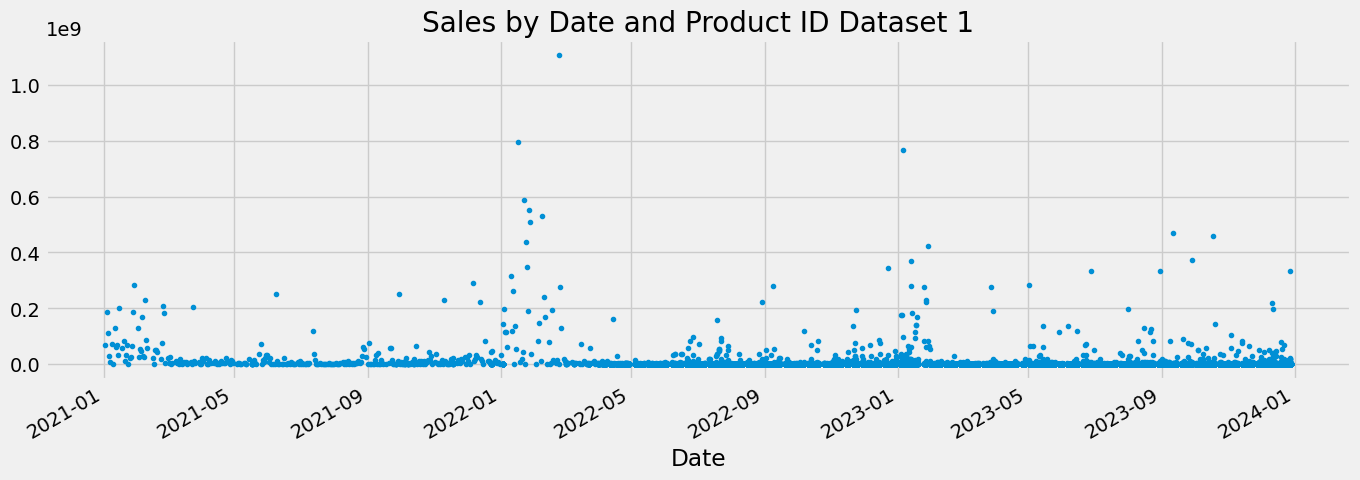

In [13]:
df['Amount'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Sales by Date and Product ID Dataset 1')
plt.show()

In [19]:
# remove the negative value which is the outlier
df = df[df['Amount'] >= 0]

In [20]:
# Outlier detection using IQR
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df = df[~((df['Amount'] < (Q1 - 1.5 * IQR)) | (df['Amount'] > (Q3 + 1.5 * IQR)))]


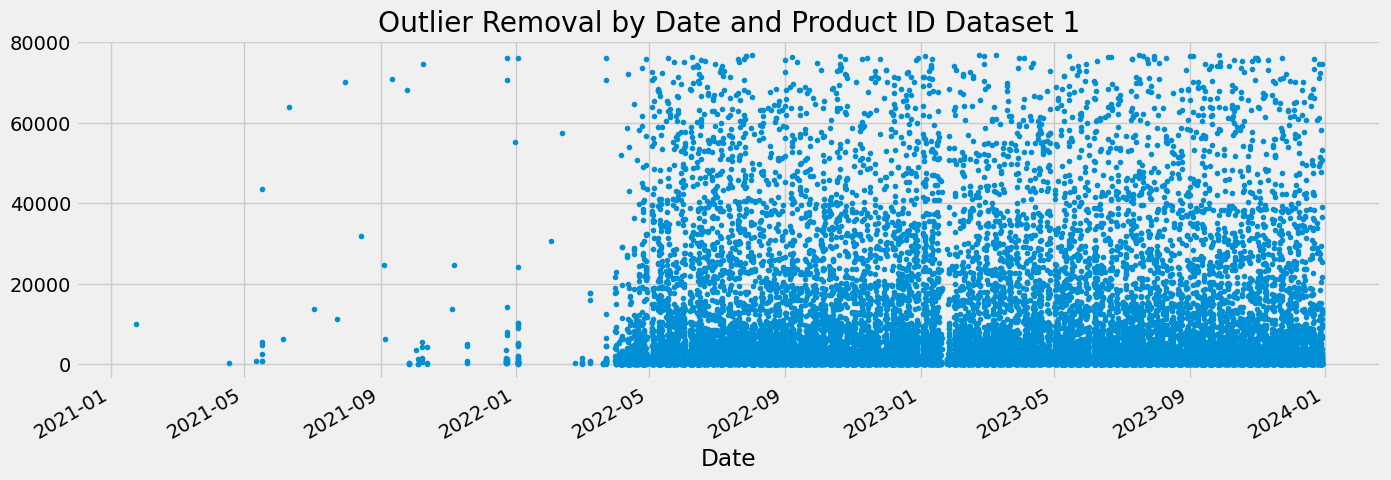

In [23]:
df['Amount'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Outlier Removal by Date and Product ID Dataset 1')
plt.show()

## Feature Engineering and Moving Averages

In [967]:
def create_feature(df):
    df = df.copy()
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    df['weekday_month_interaction'] = df['weekday'] * df['month']
    df['Amount_lag_1'] = df['Amount'].shift(1)  # Sales from the previous day
    df['Amount_lag_7'] = df['Amount'].shift(7)  # Sales from 7 days ago
    df['Amount_lag_14'] = df['Amount'].shift(14)  # Sales from 14 days ago
    df['Amount_lag_30'] = df['Amount'].shift(30)  # Sales from previous month
    df['Amount_rolling_mean_3'] = df['Amount'].rolling(window=3).mean()  # 3-day rolling mean
    df['Amount_rolling_mean_7'] = df['Amount'].rolling(window=7).mean()  # 7-day rolling mean
    df['Amount_rolling_mean_14'] = df['Amount'].rolling(window=14).mean()  # 14-day rolling mean
    df['Amount_rolling_mean_30'] = df['Amount'].rolling(window=30).mean()  # 30-day rolling mean
    df['ema_3'] = df['Amount'].ewm(span=3).mean()
    df['ema_7'] = df['Amount'].ewm(span=7).mean()
    df['ema_14'] = df['Amount'].ewm(span=14).mean()
    df['ema_30'] = df['Amount'].ewm(span=30).mean()

    # Cumulative sales trend
    df['cumulative_sales'] = df['Amount'].cumsum()
    
    return df

df = create_feature(df)

In [968]:
df.fillna(0, inplace=True)

## Spliting Data

In [969]:
train = df.loc[df.index < '01-01-2023']
test = df.loc[df.index >= '01-01-2023']

In [970]:
FEATURES = [col for col in df.columns if col != 'Amount']
TARGET = 'Amount'

In [971]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Model Training

In [972]:
reg = xgb.XGBRegressor(**xgb_params)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:17340.54269	validation_1-rmse:17257.44627


d:\programming\sales prediction\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:12:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:857.65900	validation_1-rmse:1646.91664
[200]	validation_0-rmse:580.96787	validation_1-rmse:1550.80058
[299]	validation_0-rmse:425.87052	validation_1-rmse:1521.81026


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1.0, learning_rate=0.05,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, ...)

C:\Users\USER\AppData\Local\Temp\ipykernel_54512\1820323861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


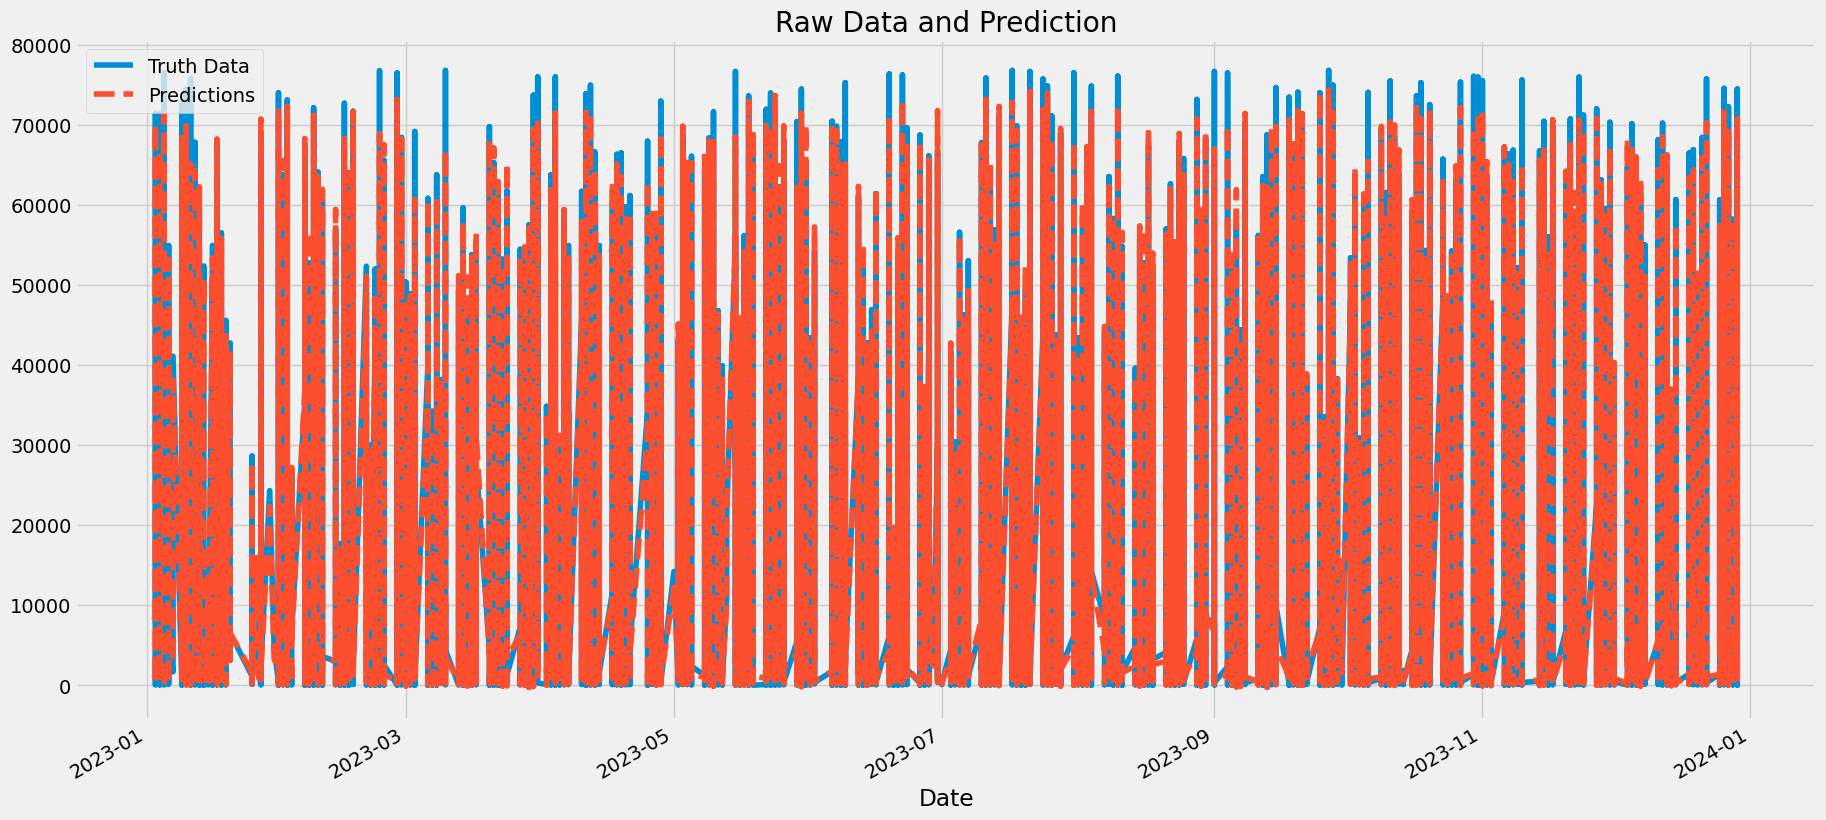

In [973]:
test['prediction'] = reg.predict(X_test)
# df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = test[['Amount']].plot(figsize=(20, 10))
test['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [974]:

training_rmse = np.sqrt(mean_squared_error(test['Amount'], test['prediction']))
print(f'RMSE Score on Test set: {training_rmse:0.2f}')

RMSE Score on Test set: 1521.81


## Preprocess the dataset 2

In [24]:
# Read the data into a pandas DataFrame
df = pd.read_csv('CodeChallenge_Dataset_2021-2023_Set 2.csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'].str.split().str[0])

df['Amount'] = df['Quantity'] * df['Amount']

# Group by 'Date' and 'ProductId', and sum the 'Amount' column
df = df.groupby(['Date', 'ProductId'])['Amount'].sum().reset_index()
df['ProductId'] = le.fit_transform(df['ProductId'])
df = df.set_index('Date')

C:\Users\USER\AppData\Local\Temp\ipykernel_36848\1942893543.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'].str.split().str[0])


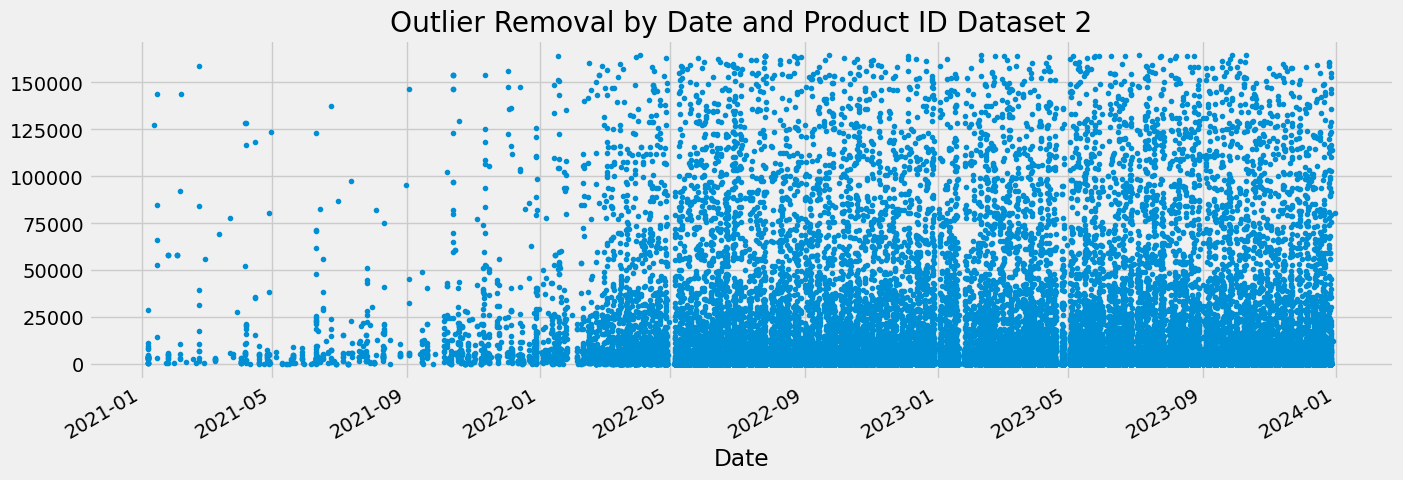

In [27]:
df['Amount'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Outlier Removal by Date and Product ID Dataset 2')
plt.show()

In [26]:
# remove the negative value which is the outlier
df = df[df['Amount'] >= 0]

# Outlier detection using IQR
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df = df[~((df['Amount'] < (Q1 - 1.5 * IQR)) | (df['Amount'] > (Q3 + 1.5 * IQR)))]

In [980]:
df = create_feature(df)

df.fillna(0, inplace=True)

X = df[FEATURES]
y = df[TARGET]

In [981]:
df[:10]

,ProductId,Amount,day,month,weekday,dayofweek,quarter,year,dayofyear,dayofmonth,...,Amount_lag_30,Amount_rolling_mean_3,Amount_rolling_mean_7,Amount_rolling_mean_14,Amount_rolling_mean_30,ema_3,ema_7,ema_14,ema_30,cumulative_sales
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-07,188,2720.00,7,1,3,3,1,2021,7,7,...,0.0,0.000000,0.000000,0.0,0.0,2720.000000,2720.000000,2720.000000,2720.000000,2720.00
2021-01-07,238,374.40,7,1,3,3,1,2021,7,7,...,0.0,0.000000,0.000000,0.0,0.0,1156.266667,1379.657143,1463.428571,1508.106667,3094.40
2021-01-07,255,28869.12,7,1,3,3,1,2021,7,7,...,0.0,10654.506667,0.000000,0.0,0.0,16992.182857,13266.992432,11932.495756,11242.995157,31963.52
2021-01-07,256,11289.60,7,1,3,3,1,2021,7,7,...,0.0,13511.040000,0.000000,0.0,0.0,13950.805333,12543.831771,11735.815809,11255.836490,43253.12
2021-01-07,265,3804.48,7,1,3,3,1,2021,7,7,...,0.0,14654.400000,0.000000,0.0,0.0,8713.992258,9679.204302,9666.542432,9560.472484,47057.60
2021-01-07,269,656.64,7,1,3,3,1,2021,7,7,...,0.0,5250.240000,0.000000,0.0,0.0,4621.368889,6935.187122,7581.811641,7818.577915,47714.24
2021-01-07,272,2462.40,7,1,3,3,1,2021,7,7,...,0.0,2307.840000,7168.091429,0.0,0.0,3533.384567,5644.735896,6503.043064,6892.192051,50176.64
2021-01-07,275,519.84,7,1,3,3,1,2021,7,7,...,0.0,1212.960000,6853.782857,0.0,0.0,2020.703373,4220.975076,5332.816648,5897.876239,50696.48
2021-01-07,278,704.16,7,1,3,3,1,2021,7,7,...,0.0,1228.800000,6900.891429,0.0,0.0,1361.143483,3270.397487,4480.573365,5155.419441,51400.64


## Evaluate the trained model using dataset 2

In [982]:
y_pred = reg.predict(X)
y_pred = pd.DataFrame(y_pred, columns=['prediction'])
df['prediction'] = y_pred.values
y_pred

,prediction
0,3445.558594
1,711.752197
2,30637.027344
3,9661.768555
4,4462.143066
...,...
42269,176.168274
42270,1774.209717
42271,67864.273438
42272,28650.361328


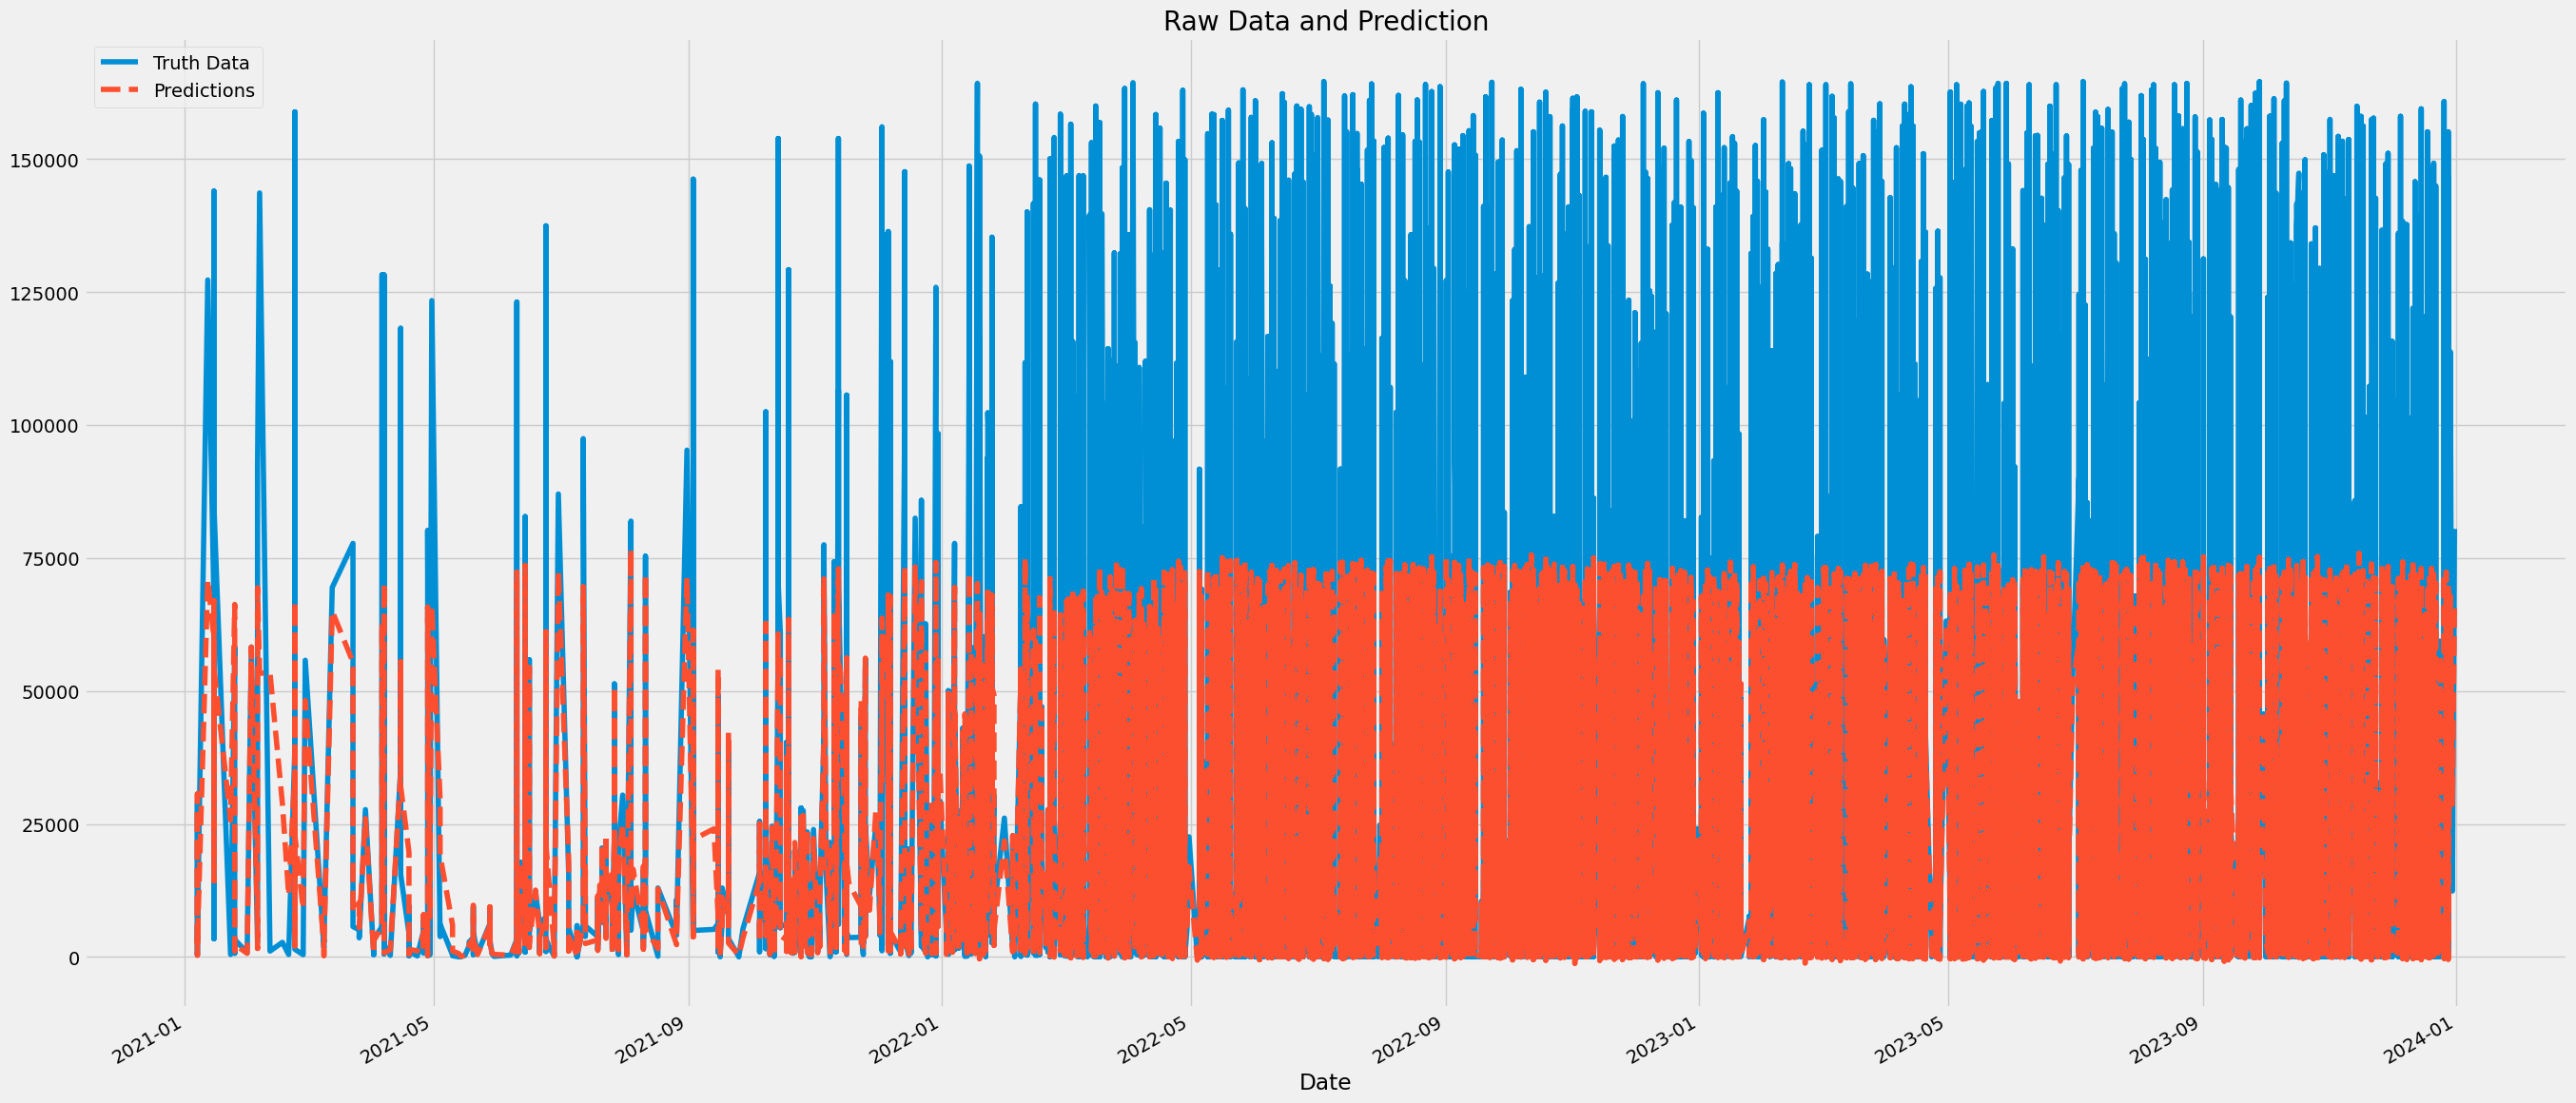

In [983]:
ax = df[['Amount']].plot(figsize=(30, 15))
df['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [984]:

evaluation_rmse = np.sqrt(mean_squared_error(df['Amount'], df['prediction']))
print(f'RMSE Score on Test set: {evaluation_rmse:0.2f}')

RMSE Score on Test set: 15429.64


## RMSE Comparison between Training and Evaluation

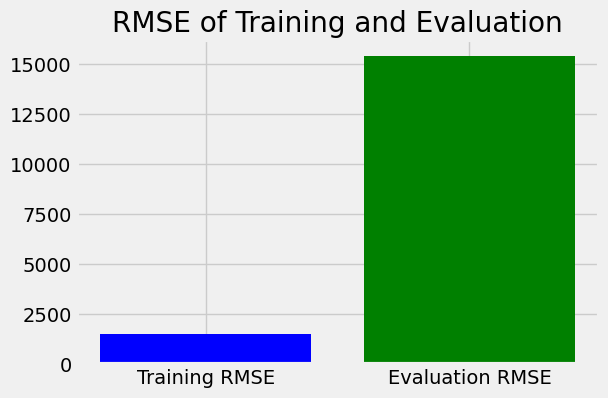

In [985]:
# Plotting the bar chart
plt.figure(figsize=(6, 4))
plt.bar(['Training RMSE', 'Evaluation RMSE'], [training_rmse, evaluation_rmse], color=['blue', 'green'])
plt.title('RMSE of Training and Evaluation')
plt.show()